<a href="https://colab.research.google.com/github/hanbiphyun/ESSA_YB/blob/main/ESAA_YB_week13_%EA%B5%B0%EC%A7%91%ED%99%94_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###파이썬 머신러닝 완벽가이드 ch7. 3~4 pg. 449-463

##7장 군집화
###03. 평균이동
- Mean shift : 중심을 군집을 중심으로 지속적으로 움직이면서 군집화 수행
- 중심을 데이터가 모여있는 밀도가 가장 높은 곳으로 이동시킴 ( <-> K 평균은 소속된 데이터의 평균 거리 중심으로 이동)
- 확률 밀도 함수 이용 -> 피크가 되는 점을 군집 중심점으로 선정

=> KDE (Kernel Density Estimation) 이용
- 평균 이동 군집화 : 주변 데이터와의 거리 값을 KDE함수값으로 입력한 뒤 그 반환값을 현재 위치에서 업데이트하면서 이동하는 방식
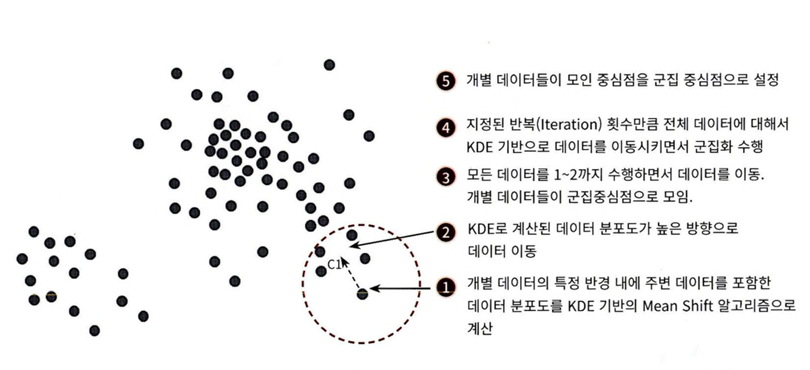

**KDE**
: 커널 함수를 통해 어떤 변수의 확률 밀도 함수 추정하는 방법
- 관측데이터 각각에 커널 함수를 적용한 값을 모두 더한 뒤 데이터 건수를 나눠 확률 밀도 함수 추정
- Ex) 정규분포, 감마분포, t분포
- 대표적 커널 함수 : 가우시안 분포
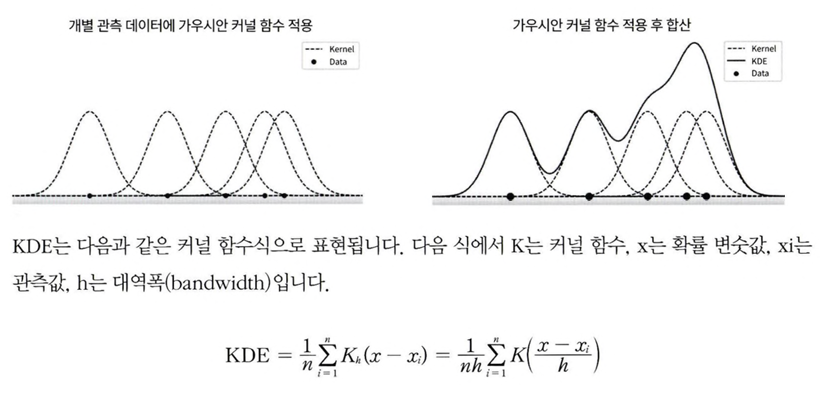
- 대역폭 h : 작을수록 좁고 뾰족한 KDE-> 과적합 하기 쉬움 <-> 매우 큰 값은 평활화된 KDE로 과소적합하기 쉬움 !
- 대역폭이 클수록 적은 군집 중심점 가짐 (적을수록 많은 수의 군집 중심점)

사이킷런 -> MeanShift 클래스 제공
- 주요 초기화 파라미터 : bandwidth = 대역폭 h

-> estimate_bandwidth() 함수로 최적의 대역폭 계산

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y= make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth= 0.8)
cluster_labels= meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


- 지나치게 세분화된 군집화 -> bandwidth값 높이자

In [3]:
meanshift= MeanShift(bandwidth=1)
cluster_labels=meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


- 최적화된 bandwidth값 찾기 위해 estimate_bandwidth() 사용

In [4]:
from sklearn.cluster import estimate_bandwidth

bandwidth= estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [5]:
import pandas as pd

clusterDF = pd.DataFrame(data= X, columns=['ftr1', 'ftr2'])
clusterDF['target']= y

#estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth= estimate_bandwidth(X)

meanshift= MeanShift(bandwidth= best_bandwidth)
cluster_labels= meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


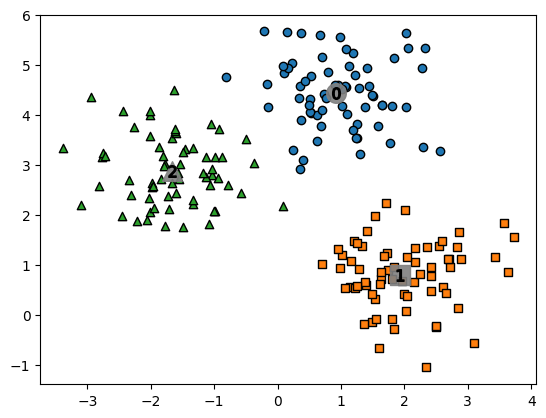

In [7]:
from ast import increment_lineno
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']= cluster_labels
centers= meanshift.cluster_centers_
unique_labels= np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster= clusterDF[clusterDF['meanshift_label']==label]
    center_x_y= centers[label]

    #군집별로 다른 마커로 산점도 적용
    plt.scatter(x= label_cluster['ftr1'], y= label_cluster['ftr2'], edgecolor='k', marker= markers[label])

    #군집별 중심 표현
    plt.scatter(x= center_x_y[0], y= center_x_y[1], s=200, color='gray', alpha=0.9,
                marker=markers[label])
    plt.scatter(x=center_x_y[0], y= center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [8]:
# target값과 군집 label 값 비교
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


평균이동의 장점

- 유연한 군집화, 이상치 영향 작음
- 미리 군집 개수 정할 필요없음

단점

- 수행시간 김
- bandwidth크기에 따른 군집화 영향도 큼

-> 컴퓨터비전 영역에서 많이 사용, 이미지나 영상데이터에서 개체 구분하거나 움직임 추적하는데 뛰어난 역할 수행

###04. GMM (Gaussian Mixture Model)
: 군집화를 적용하고자 하는 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화 수행 방식
- 1000개의 데이터세트가 있다면 이를 구성하는 여러 개의 정규분포 곡선 추출-> 개별 데이터가 어떤 정규 분포에 속하는 지 결정

== **모수추정**
1. 개별 정규 분포의 평균과 분산
2. 각 데이터가 어떤 정규 분포에 해당되는지 확률
- GMM은 EM 알고리즘 사용
- GaussianMixture 클래스 지원

-> 주요 초기화 파라미터 : n_components (가우시안 혼합 모델의 총 개수)



In [10]:
#GMM 이용 붓꽃 데이터 세트 군집화 - 확률기반
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris= load_iris()
feature_names=['sepal_length', 'sepal_width', 'petal_length','petal_width']

# 좀더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF= pd.DataFrame(data= iris.data, columns= feature_names)
irisDF['target']= iris.target


In [11]:
from sklearn.mixture import GaussianMixture

gmm= GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels= gmm.predict(iris.data)

#군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster']= gmm_cluster_labels
irisDF['target']= iris.target

#target값에 따라 gmm_cluster값이 어떻게 매핑됐는지 확인
iris_result= irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [12]:
# k평균 군집화와 비교
kmeans= KMeans(n_clusters=3, init= 'k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels= kmeans.predict(iris.data)
irisDF['kmeans_cluster']= kmeans_cluster_labels
iris_result= irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


** GMM과 K-평균의 비교**
- KMeans는 원형의 범위에서 군집화 수행 -> cluster_std 작게 설정 시 데이터가 원형 형태로 분산
  - 데이터가 길게 퍼져있으면 군집화 잘 X
- visualize_cluster_plot(clusterobj, dataframe, label_name, iscluster= True) 함수로 군집시각화
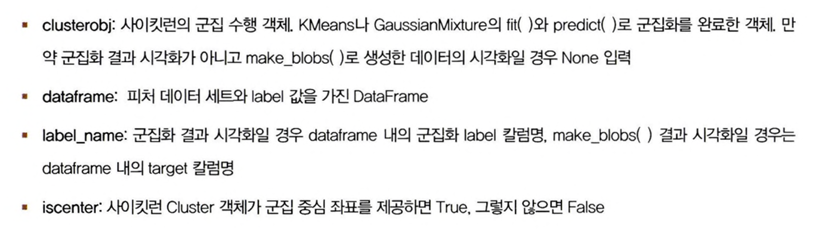

In [13]:

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.datasets import make_blobs


%matplotlib inline


def visualize_cluster_plot(cluster_result=None, dataframe=None, label_name='target', iscenter=True):

    if dataframe is None:

        print("Error: DataFrame is required.")

        return


    unique_labels = np.unique(dataframe[label_name])

    markers = ['o', 's', '^', 'x', '*', 'D', '+', 'v', '<', '>']


    for label in unique_labels:

        label_cluster = dataframe[dataframe[label_name] == label]

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k',

                    marker=markers[label % len(markers)])



        if iscenter and cluster_result is not None and hasattr(cluster_result, 'cluster_centers_'):

            # Assuming cluster_result has a .cluster_centers_ attribute

            center_x_y = cluster_result.cluster_centers_[label]

            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9,

                        marker=markers[label % len(markers)])

            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k',

                        marker='$%d$' % label)

    plt.show()

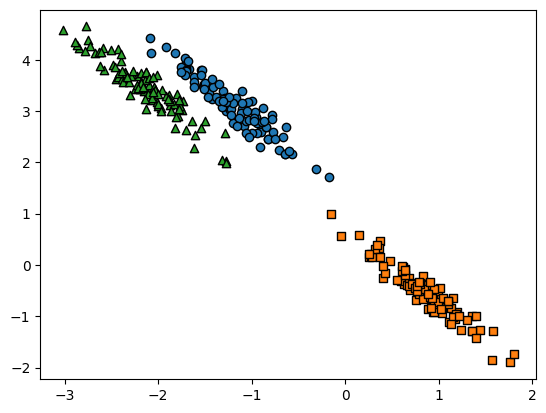

In [14]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦
X, y= make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터세트를 생성하기 위해 변환함
transformation= [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso= np.dot(X, transformation)

# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF= pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target']=y

# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

- KMeans 군집화 정확성 떨어짐

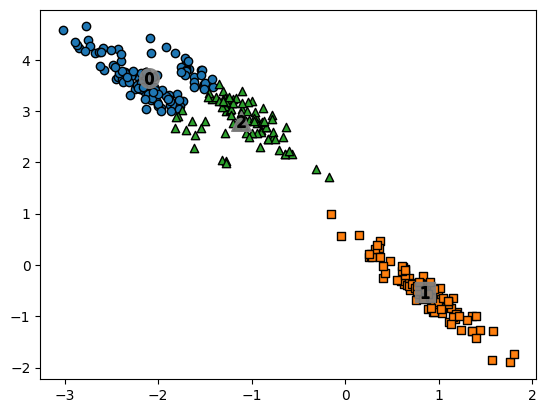

In [15]:
# 3개의 군집 기반 KMeans를 X_aniso 데이터 세트에 적용
kmeans= KMeans(3, random_state=0)
kmeans_label= kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label']= kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

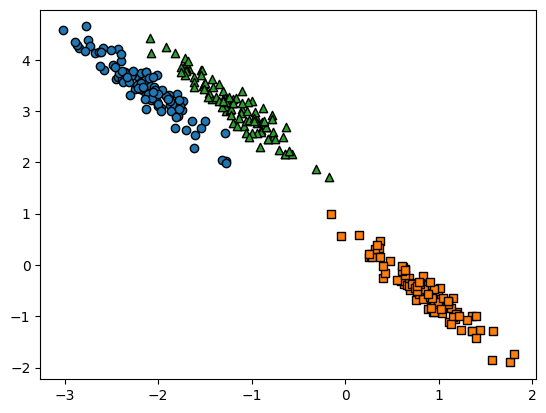

In [22]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm= GaussianMixture(n_components=3, random_state=0)
gmm_label= gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture 는 cluster_centers_ 속성이 없으므로 iscenter 를 False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_target', iscenter=False)

- 데이터가 방향에 따라 정확하게 군집화됐음

In [23]:
print('### KMeans Clusterig ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clusterig ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
